In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [2]:
def match_attack_graphs(file_location_spdfa, file_location_sinks):
    """
    Match attack graphs from two directories based on their names.

    Args:
        file_location_spdfa (str): Path to the directory containing SPDFA attack graphs in DOT format.
        file_location_sinks (str): Path to the directory containing sinks attack graphs in DOT format.

    Returns:
        list: A list containing two sublists: matched_attack_graphs and unmatched_attack_graphs.

    """
    # Retrieve the SPDFA attack graphs from the specified directory
    spdfa_attack_graphs = [(file[35:], nx.nx_pydot.read_dot(file_location_spdfa + "/" + file)) for file in os.listdir(file_location_spdfa) if file.endswith('.dot')]

    # Retrieve the sinks attack graphs from the specified directory
    sinks_attack_graphs = [(file[35:], nx.nx_pydot.read_dot(file_location_sinks + "/" + file)) for file in os.listdir(file_location_sinks) if file.endswith('.dot')]

    # Remove the last node from each sinks attack graph (only for proposed graphs)
    for x in sinks_attack_graphs:
        x[1].remove_node(list(x[1].nodes())[-1])

    # Initialize lists to store matched and unmatched attack graphs
    matched_attack_graphs = []
    unmatched_attack_graphs = []

    # Match SPDFA attack graphs with corresponding sinks attack graphs
    for (name_spdfa, spdfa) in spdfa_attack_graphs:
        is_unmatched = True
        for (name_sinks, sinks) in sinks_attack_graphs:
            if name_sinks == name_spdfa:
                matched_attack_graphs.append((name_sinks, spdfa, sinks))
                is_unmatched = False
        if is_unmatched:
            unmatched_attack_graphs.append((name_spdfa, spdfa))

    # Return the matched and unmatched attack graphs
    return [matched_attack_graphs, unmatched_attack_graphs]


In [3]:
(matched_attack_graphs, unmatched_attack_graphs) = match_attack_graphs("C:/Users/alexd/PycharmProjects/SAGE/baseline-2018AGs", "C:/Users/alexd/PycharmProjects/SAGE/bobeala2")

In [4]:
def simplicity(graph: nx.classes.multidigraph.MultiDiGraph) -> float:
    """
    Calculate the simplicity of a directed graph.

    The simplicity of a graph is defined as the ratio of the number of nodes
    to the number of edges.

    Args:
        graph (nx.classes.multidigraph.MultiDiGraph): The multi-graph.

    Returns:
        float: The simplicity of the graph.

    """
    return len(graph.nodes) / (len(graph.edges) * 1.0)

In [5]:
#Create dict with all size and complexity values and deltas
complexity_values = [{"name": name, "nodes_base": len(spdfa.nodes), "edges_base": len(spdfa.edges), "simplicity_base": simplicity(spdfa), "nodes_sinks": len(sinks.nodes), "edges_sinks": len(sinks.edges), "simplicity_sinks": simplicity(sinks), "simplicity_difference": abs(simplicity(spdfa) - simplicity(sinks)), "size_difference": len(spdfa.nodes) - len(sinks.nodes)} for (name, spdfa, sinks)  in matched_attack_graphs]
# Sort dict based on simplicity delta
complexity_values.sort(key= lambda a: a["simplicity_difference"], reverse=True)

In [6]:
# Template to save info in a log file if desired
with open('complexity_results.txt', 'w') as f:
    f.write("Name" + "\t\t\t" + "S_Comp" + "\t\t\t" + "S_Nodes" + "\t\t\t" + "S_Edges" + "\t\t\t" + "P_Comp" + "\t\t\t" + "P_Nodes" + "\t\t\t" + "P_Nodes" + "\t\t\t" + "Diff_comp" + "\n")
    for result in complexity_values:
        f.write(result["name"] + "\t\t\t")
        f.write(str(result["simplicity_base"]) + "\t\t\t")
        f.write(str(result["nodes_base"]) + "\t\t\t")
        f.write(str(result["edges_base"]) + "\t\t\t")
        f.write(str(result["simplicity_sinks"]) + "\t\t\t")
        f.write(str(result["nodes_sinks"]) + "\t\t\t")
        f.write(str(result["edges_sinks"]) + "\t\t\t")
        f.write(str(result["simplicity_difference"]) + "\t\t\t")
        f.write(str(result["size_difference"]) + "\n")

In [7]:
result_df = pd.DataFrame(complexity_values)
simplicity10 = result_df.head(10)
# Top 10 simplicity deltas
simplicity10

,name,nodes_base,edges_base,simplicity_base,nodes_sinks,edges_sinks,simplicity_sinks,simplicity_difference,size_difference
0,victim-10.0.0.176-DATAMANIPULATIONhttp.dot,31,59,0.525424,28,59,0.474576,0.050847,3
1,victim-10.0.0.24-RESOURCEHIJACKINGwapwsp.dot,24,40,0.600000,22,40,0.550000,0.050000,2
2,victim-10.0.0.24-DATADELIVERYhttp.dot,18,30,0.600000,17,30,0.566667,0.033333,1
3,victim-10.0.0.24-DATAMANIPULATIONhttp.dot,28,40,0.700000,27,40,0.675000,0.025000,1
4,victim-10.0.1.46-RESOURCEHIJACKINGuscli.dot,34,53,0.641509,33,53,0.622642,0.018868,1
5,victim-10.0.0.176-DATADELIVERYhttp.dot,32,64,0.500000,31,64,0.484375,0.015625,1
6,victim-10.0.1.5-NETWORKDOShttp.dot,23,66,0.348485,22,66,0.333333,0.015152,1
7,victim-10.0.0.22-RESOURCEHIJACKINGhttp.dot,22,66,0.333333,21,66,0.318182,0.015152,1
8,victim-10.0.0.11-DATADELIVERYhttp.dot,22,69,0.318841,22,69,0.318841,0.000000,0
9,victim-10.0.0.11-DATAEXFILTRATIONhttp.dot,22,42,0.523810,22,42,0.523810,0.000000,0


In [8]:
def estimate_coef(x, y):
    """
    Estimate the coefficients of a simple linear regression model.

    Given two arrays, x and y, representing observations, this function calculates
    the coefficients of a simple linear regression model (y = b0 + b1 * x).

    Args:
        x (array-like): The independent variable array.
        y (array-like): The dependent variable array.

    Returns:
        tuple: A tuple containing the regression coefficients (b0, b1).

    """
    # number of observations/points
    n = np.size(x)

    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)

    # calculating cross-deviation and deviation about x
    SS_xy = np.sum([xx * yy for xx, yy in zip(x, y)]) - n*m_y*m_x
    SS_xx = np.sum([xx * yy for xx, yy in zip(x, x)]) - n*m_x*m_x

    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return (b_0, b_1)

In [9]:
# Compute lower and upper percentile based on node count
l = sorted([ag["nodes_base"] for ag in complexity_values] + [ag["nodes_sinks"] for ag in complexity_values])
lower = np.percentile(l,25)
upper = np.percentile(l,75)
print(lower, upper)

12.25 22.0


In [10]:
# Filter attack graphs based on complexity values
complex_base = [ag for ag in complexity_values if ag["nodes_base"] >= 22]
complex_sinks = [ag for ag in complexity_values if ag["nodes_sinks"] >= 22]

simple_base = [ag for ag in complexity_values if ag["nodes_base"] < 13]
simple_sinks = [ag for ag in complexity_values if ag["nodes_sinks"] < 13]

middle_base = [ag for ag in complexity_values if 13 <= ag["nodes_base"] < 22]
middle_sinks = [ag for ag in complexity_values if 13 <= ag["nodes_sinks"] < 22]

# Estimate coefficients for simplicity regression
(a, b) = estimate_coef([ag["nodes_base"] for ag in middle_base] + [ag["nodes_sinks"] for ag in middle_sinks],
                       [ag["simplicity_base"] for ag in middle_base] + [ag["simplicity_sinks"] for ag in middle_sinks])

# Classify attack graphs as complex or simple based on the regression line
for ag in middle_base:
    if a + ag["nodes_base"] * b > ag["simplicity_base"]:
        complex_base.append(ag)
    else:
        simple_base.append(ag)

for ag in middle_sinks:
    if a + ag["nodes_sinks"] * b > ag["simplicity_sinks"]:
        complex_sinks.append(ag)
    else:
        simple_sinks.append(ag)

# Find changes from simple to complex and complex to simple
changes_s_to_c = []
for ag in simple_base:
    if ag in complex_sinks:
        changes_s_to_c.append(ag)

changes_c_to_s = []
for ag in complex_base:
    if ag in simple_sinks:
        changes_c_to_s.append(ag)


In [11]:
print(len(complex_base))
print(len(simple_base))
print(len(complex_sinks))
print(len(simple_sinks))

41
34
42
33


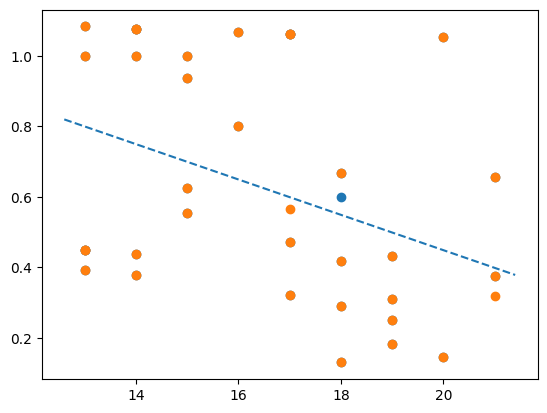

In [12]:
# Plot the linear regression and all the points on which it is constructed
plt.scatter(np.array([ag["nodes_base"] for ag in middle_base]), np.array([ag["simplicity_base"] for ag in middle_base]))
plt.scatter(np.array([ag["nodes_sinks"] for ag in middle_sinks]), np.array([ag["simplicity_sinks"] for ag in middle_sinks]))
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = a + b * (x_vals)
plt.plot(x_vals, y_vals, '--')

In [13]:
s_to_c = pd.DataFrame(changes_s_to_c)
s_to_c

,name,nodes_base,edges_base,simplicity_base,nodes_sinks,edges_sinks,simplicity_sinks,simplicity_difference,size_difference
0,victim-10.0.0.24-DATADELIVERYhttp.dot,18,30,0.6,17,30,0.566667,0.033333,1


In [14]:
c_to_s = pd.DataFrame(changes_c_to_s)
c_to_s

""


In [15]:
complexity_values.sort(key= lambda a: a["size_difference"], reverse=True)
size_minus = pd.DataFrame(complexity_values)
size_minus5 = size_minus.head(5)
size_minus5

,name,nodes_base,edges_base,simplicity_base,nodes_sinks,edges_sinks,simplicity_sinks,simplicity_difference,size_difference
0,victim-10.0.0.176-DATAMANIPULATIONhttp.dot,31,59,0.525424,28,59,0.474576,0.050847,3
1,victim-10.0.0.24-RESOURCEHIJACKINGwapwsp.dot,24,40,0.600000,22,40,0.550000,0.050000,2
2,victim-10.0.0.24-DATADELIVERYhttp.dot,18,30,0.600000,17,30,0.566667,0.033333,1
3,victim-10.0.0.24-DATAMANIPULATIONhttp.dot,28,40,0.700000,27,40,0.675000,0.025000,1
4,victim-10.0.1.46-RESOURCEHIJACKINGuscli.dot,34,53,0.641509,33,53,0.622642,0.018868,1


In [16]:
complexity_values.sort(key= lambda a: a["size_difference"], reverse=False)
size_plus = pd.DataFrame(complexity_values)
size_plus5 = size_plus.head(2)
size_plus5

,name,nodes_base,edges_base,simplicity_base,nodes_sinks,edges_sinks,simplicity_sinks,simplicity_difference,size_difference
0,victim-10.0.0.11-DATADELIVERYhttp.dot,22,69,0.318841,22,69,0.318841,0.0,0
1,victim-10.0.0.11-DATAEXFILTRATIONhttp.dot,22,42,0.523810,22,42,0.523810,0.0,0


In [17]:
print(len(matched_attack_graphs))
spdfa_attack_graphs = [1 for file in os.listdir("C:/Users/alexd/PycharmProjects/SAGE/baseline-2018AGs") if file.endswith('.dot')]
sinks_attack_graphs = [1 for file in os.listdir("C:/Users/alexd/PycharmProjects/SAGE/mergesinks-2018AGs") if file.endswith('.dot')]
print(len(spdfa_attack_graphs))
print(len(sinks_attack_graphs))
print(unmatched_attack_graphs)

75
75
75
[]


In [18]:
c = 0
dif = 0
start1 = 0
start2 = 0
nodes1 = 0
nodes2 = 0
max1 = 0
max2 = 0

# Iterate over the matched attack graphs
for (name, spdfa, sinks) in matched_attack_graphs:
    # Get the list of nodes for the SPDFA and sinks attack graphs
    spdfa_nodes_list = list(spdfa.nodes(data=True))
    sinks_nodes_list = list(sinks.nodes(data=True))

    # Initialize counters for yellow nodes in SPDFA and sinks
    c_spdfa = 0
    c_sinks = 0

    # Count the number of yellow nodes in SPDFA graph
    for x in spdfa_nodes_list:
        if 'fillcolor' in x[1]:
            if x[1]["fillcolor"] == 'yellow':
                c_spdfa += 1

    # Count the number of yellow nodes in sinks graph
    for x in sinks_nodes_list:
        if 'fillcolor' in x[1]:
            if x[1]["fillcolor"] == 'yellow':
                c_sinks += 1

    # Compare the number of yellow nodes between SPDFA and sinks graphs
    if c_spdfa != c_sinks:
        print(name, c_spdfa, c_sinks, c_sinks - c_spdfa)
        dif += c_sinks - c_spdfa
        c += 1

    # Accumulate yellow node counts and total nodes for statistics
    start1 += c_spdfa
    start2 += c_sinks
    nodes1 += len(spdfa_nodes_list)
    nodes2 += len(sinks_nodes_list)

    # Track the maximum number of nodes in SPDFA and sinks graphs
    if len(spdfa_nodes_list) > max1:
        max1 = len(spdfa_nodes_list)
    if len(sinks_nodes_list) > max2:
        max2 = len(sinks_nodes_list)

print(c)
print(dif)
print(start1, start2)
print(nodes1 / 108, nodes2 / 108)
print(max1, max2)


victim-10.0.0.176-DATAMANIPULATIONhttp.dot 7 6 -1
1
-1
203 202
11.925925925925926 11.824074074074074
34 33


In [19]:
c = 0
kk = 0
sum_sinks = 0

# Iterate over the matched attack graphs
for (name, spdfa, sinks) in matched_attack_graphs:
    # Get the list of nodes for the SPDFA and sinks attack graphs
    spdfa_nodes_list = list(spdfa.nodes(data=True))
    sinks_nodes_list = list(sinks.nodes(data=True))

    # Initialize counters for dotted nodes in SPDFA and sinks
    c_spdfa = 0
    c_sinks = 0

    # Count the number of dotted nodes in SPDFA graph
    for x in spdfa_nodes_list:
        if 'style' in x[1]:
            if x[1]["style"] == '"dotted"':
                c_spdfa += 1

    # Count the number of dotted nodes in sinks graph
    for x in sinks_nodes_list:
        if 'style' in x[1]:
            if x[1]["style"] == '"dotted"':
                c_sinks += 1

    # Compare the number of dotted nodes between SPDFA and sinks graphs
    if c_spdfa != c_sinks:
        print(name, c_spdfa, c_sinks)
        c += 1
        sum_sinks += c_spdfa

    kk += 1

print(c)
print(kk)
print(sum_sinks)


victim-10.0.0.11-DATADELIVERYhttp.dot 3 0
victim-10.0.0.11-DATAEXFILTRATIONhttp.dot 3 0
victim-10.0.0.11-DATAMANIPULATIONhttp.dot 3 0
victim-10.0.0.11-NETWORKDOShttp.dot 1 0
victim-10.0.0.176-DATADELIVERYhttp.dot 6 0
victim-10.0.0.176-DATAEXFILTRATIONetlservicemgr.dot 3 0
victim-10.0.0.176-DATAEXFILTRATIONhttp.dot 2 0
victim-10.0.0.176-DATAMANIPULATIONetlservicemgr.dot 2 0
victim-10.0.0.176-DATAMANIPULATIONhttp.dot 6 0
victim-10.0.0.176-RESOURCEHIJACKINGetlservicemgr.dot 3 0
victim-10.0.0.20-DATAMANIPULATIONremotewarecl.dot 2 0
victim-10.0.0.20-RESOURCEHIJACKINGremotewarecl.dot 4 0
victim-10.0.0.22-DATADELIVERYhttp.dot 2 0
victim-10.0.0.22-DATAMANIPULATIONhttp.dot 2 0
victim-10.0.0.22-NETWORKDOShttp.dot 1 0
victim-10.0.0.23-DATADELIVERYunknown.dot 4 0
victim-10.0.0.23-DATAMANIPULATIONunknown.dot 2 0
victim-10.0.0.23-RESOURCEHIJACKINGunknown.dot 4 0
victim-10.0.0.24-DATADELIVERYcslistener.dot 4 0
victim-10.0.0.24-DATADELIVERYhttp.dot 2 0
victim-10.0.0.24-DATADELIVERYwapwsp.dot 6 0
victi

In [20]:
for (name, spdfa, sinks) in matched_attack_graphs:
    spdfa_nodes_list = list(spdfa.nodes(data = True))
    sinks_nodes_list = list(sinks.nodes(data = True))

    source_spdfa = spdfa_nodes_list[0]
    source_sinks = sinks_nodes_list[0]

    spdfa_final_objectives = list(spdfa.predecessors(source_spdfa[0]))
    sinks_final_objectives = list(sinks.predecessors(source_sinks[0]))
    print(spdfa.in_degree(spdfa_final_objectives[0]))
    break

5


In [21]:
c = 0
dif = 0
obj1 = 0
obj2 = 0

# Iterate over the matched attack graphs
for (name, spdfa, sinks) in matched_attack_graphs:
    # Get the list of nodes for the SPDFA and sinks attack graphs
    spdfa_nodes_list = list(spdfa.nodes(data=True))
    sinks_nodes_list = list(sinks.nodes(data=True))

    # Initialize counters for salmon-colored nodes in SPDFA and sinks
    c_spdfa = 0
    c_sinks = 0

    # Count the number of salmon-colored nodes in SPDFA graph
    for x in spdfa_nodes_list:
        if 'fillcolor' in x[1]:
            if x[1]["fillcolor"] == 'salmon':
                c_spdfa += 1

    # Count the number of salmon-colored nodes in sinks graph
    for x in sinks_nodes_list:
        if 'fillcolor' in x[1]:
            if x[1]["fillcolor"] == 'salmon':
                c_sinks += 1

    # Compare the number of salmon-colored nodes between SPDFA and sinks graphs
    if c_spdfa != c_sinks:
        print(name, c_spdfa, c_sinks, c_sinks - c_spdfa)
        dif += c_sinks - c_spdfa
        c += 1

    # Accumulate salmon-colored node counts for statistics
    obj1 += c_spdfa
    obj2 += c_sinks

print(c)
print(dif)
print(obj1, obj2)


0
0
174 174


In [22]:
sum_nodes_base = 0
sum_nodes_sinks = 0
sum_edges_base = 0
sum_edges_sinks = 0
for x in complexity_values:
    sum_nodes_base += x["nodes_base"]
    sum_nodes_sinks += x["nodes_sinks"]
    sum_edges_base += x["edges_base"]
    sum_edges_sinks += x["edges_sinks"]
# Percent dif between the 2 implementations
print(1 - (sum_nodes_sinks / (sum_nodes_base * 1.0)))
print(1 - (sum_edges_sinks / (sum_edges_base * 1.0)))

0.008540372670807428
0.0


In [23]:
sum_simplicity_base = 0
sum_simplicity_sinks = 0
for x in complexity_values:
    sum_simplicity_base += x["simplicity_base"]
    sum_simplicity_sinks += x["simplicity_sinks"]
print(sum_simplicity_base / (len(complexity_values) * 1.0))
print(sum_simplicity_sinks / (len(complexity_values) * 1.0))

0.6689696450796919
0.6659832884691347


In [24]:
print(len([x for x in complexity_values if x["simplicity_difference"] == 0]))

67


In [25]:
print(len([x for x in complexity_values if x["size_difference"] == 0]))

67


In [26]:
dot_file_path_spdfa = "C:/Users/alexd/PycharmProjects/SAGE/baseline-2017AGs/baseline-2017.txt-attack-graph-for-victim-10.0.0.22-DATAEXFILTRATIONunknown.dot"
G_spdfa = nx.nx_pydot.read_dot(dot_file_path_spdfa)  # Create NetworkX graph from the DOT file

print(nx.density(G_spdfa))

dot_file_path_sinks = "C:/Users/alexd/PycharmProjects/SAGE/mergesinks-2017AGs/mergesinks-2017.txt-attack-graph-for-victim-10.0.0.22-DATAEXFILTRATIONunknown.dot"
G_sinks = nx.nx_pydot.read_dot(dot_file_path_sinks)  # Create NetworkX graph from the DOT file
G_sinks.remove_node(list(G_sinks.nodes())[-1])
print(nx.density(G_sinks))

0.08187134502923976
0.15384615384615385


In [27]:
# Calculate degree centrality for Graph1 (G_spdfa) and Graph2 (G_sinks)
degree_centrality_G1 = nx.degree_centrality(G_spdfa)  # Degree centrality for Graph1
degree_centrality_G2 = nx.degree_centrality(G_sinks)  # Degree centrality for Graph2

# Get the keys and values of the degree centrality dictionaries for Graph1
keys = list(degree_centrality_G1.keys())
values = list(degree_centrality_G1.values())

# Sort the values in descending order and get the indices of the top 3 values
sorted_value_index = np.argsort(values)[::-1][:3]

# Create a sorted dictionary with the top 3 degree centrality nodes and their values for Graph1
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

# Get the keys (top 3 degree centrality nodes) for Graph1
top3_G1 = sorted_dict.keys()

# Get the keys and values of the degree centrality dictionaries for Graph2
keys2 = list(degree_centrality_G2.keys())
values2 = list(degree_centrality_G2.values())

# Sort the values in descending order and get the indices of the top 3 values
sorted_value_index2 = np.argsort(values2)[::-1][:3]

# Create a sorted dictionary with the top 3 degree centrality nodes and their values for Graph2
sorted_dict2 = {keys2[i]: values2[i] for i in sorted_value_index2}

# Get the keys (top 3 degree centrality nodes) for Graph2
top3_G2 = sorted_dict2.keys()

# Print the top 3 degree centrality nodes for Graph1 and Graph2
print(top3_G1)
print(top3_G2)


dict_keys(['VULNERABILTY DISCOVERY\nmysql', 'INFO DISCOVERY\nxdmcp', 'SERVICE DISCOVERY\nunknown'])
dict_keys(['VULNERABILTY DISCOVERY\nmysql', 'BRUTE FORCE CREDENTIALS\nunknown | ID: 98', 'ACCOUNT MANIPULATION\nsnmp | ID: 117'])


In [28]:
from networkx.algorithms import community

# Community detection on Graph1
communities_G1 = community.greedy_modularity_communities(G_spdfa)

# Community detection on Graph2
communities_G2 = community.greedy_modularity_communities(G_sinks)

# Number of communities in Graph1
num_communities_G1 = len(communities_G1)

# Number of communities in Graph2
num_communities_G2 = len(communities_G2)

print(f"Number of communities in Graph1: {num_communities_G1}")
print(f"Number of communities in Graph2: {num_communities_G2}")

# Modularity of communities in Graph1
modularity_G1 = community.modularity(G_spdfa, communities_G1)

# Modularity of communities in Graph2
modularity_G2 = community.modularity(G_sinks, communities_G2)

print(f"Modularity of communities in Graph1: {modularity_G1}")
print(f"Modularity of communities in Graph2: {modularity_G2}")


Number of communities in Graph1: 4
Number of communities in Graph2: 4
Modularity of communities in Graph1: 0.49489795918367346
Modularity of communities in Graph2: 0.421875


In [29]:
from networkx.algorithms import clustering

# Average clustering coefficient per community in Graph1
clustering_coefficients_G1 = []
for community_nodes in communities_G1:
    subgraph = nx.Graph(G_spdfa).subgraph(community_nodes)
    clustering_coefficient = nx.average_clustering(subgraph)
    clustering_coefficients_G1.append(clustering_coefficient)

# Average clustering coefficient per community in Graph2
clustering_coefficients_G2 = []
for community_nodes in communities_G2:
    subgraph = nx.Graph(G_sinks).subgraph(community_nodes)
    clustering_coefficient = nx.average_clustering(subgraph)
    clustering_coefficients_G2.append(clustering_coefficient)

print(f"Average clustering coefficients in Graph1 communities: {clustering_coefficients_G1}")
print(f"Average clustering coefficients in Graph2 communities: {clustering_coefficients_G2}")


Average clustering coefficients in Graph1 communities: [0.0, 0.3333333333333333, 0.0, 0.0]
Average clustering coefficients in Graph2 communities: [0.0, 0.5833333333333333, 0.0, 0.0]


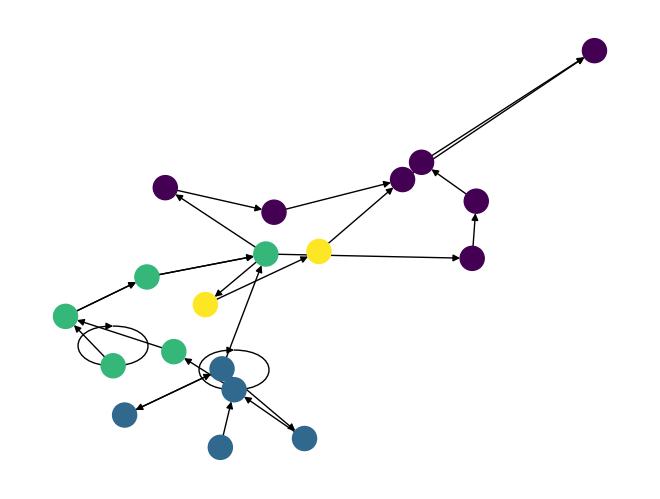

In [30]:
# Create a dictionary to map nodes to their respective community IDs
community_mapping = {}
for i, comm in enumerate(communities_G1):
    for node in comm:
        community_mapping[node] = i

# Create a list of colors for nodes based on their community IDs
colors = [community_mapping[node] for node in G_spdfa.nodes()]

# Draw the graph with nodes colored by their community membership
pos = nx.spring_layout(G_spdfa)  # Layout algorithm for node positioning
nx.draw(G_spdfa, pos, node_color=colors, with_labels=False)

# Show the plot
plt.show()

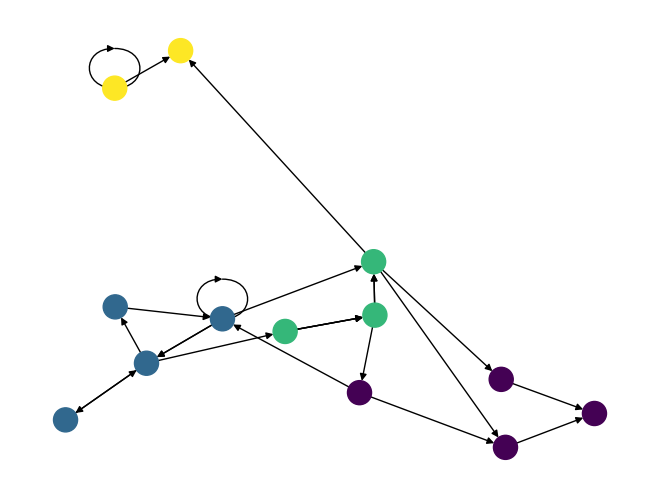

In [31]:
# Create a dictionary to map nodes to their respective community IDs
community_mapping = {}
for i, comm in enumerate(communities_G2):
    for node in comm:
        community_mapping[node] = i

# Create a list of colors for nodes based on their community IDs
colors = [community_mapping[node] for node in G_sinks.nodes()]

# Draw the graph with nodes colored by their community membership
pos = nx.spring_layout(G_sinks)  # Layout algorithm for node positioning
nx.draw(G_sinks, pos, node_color=colors, with_labels=False)

# Show the plot
plt.show()